# LGBM을 활용한 베이스라인

In [18]:
import pandas as pd
import os
import random
import numpy as np

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import wandb 
from tqdm import tqdm

In [22]:
pd.options.display.max_columns = 100

## 1. 데이터 로딩

In [2]:
config = {'learning_rate': 0.001, 
      'objective': 'binary', 
      'metric': 'binary_logloss',
      'sub_feature': 0.5, 
      'num_leaves': 10, 
      'min_data': 50, 
      'max_depth': 10}

In [3]:
wandb.login()

wandb: Currently logged in as: heiness (recsys-10). Use `wandb login --relogin` to force relogin


True

In [57]:
data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요!

# LOAD TRAINDATA
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
train_data = pd.read_csv(csv_file_path)

# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_data = pd.read_csv(test_csv_file_path)
# test_data['answerCode'] = test_data['answerCode'].replace(-1, np.nan)

# # LEAVE LAST INTERACTION ONLY
# train_df = test_df[test_df['userID'] == test_df['userID'].shift(-1)]
# test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# df = pd.concat([df, train_df], ignore_index=True)

## 2. Feature Engineering

In [52]:
def feature_engineering(train, test):
    ## train, test data concat
    train['train'] = 1
    test['train'] = 0
    total = pd.concat([train, test], ignore_index=True)
    # total['answerCode'] = total['answerCode'].fillna(0.5)
    total = elo(total)
    
    ## 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    total.sort_values(by=['userID','Timestamp'], inplace=True)
    total['Timestamp'] = pd.to_datetime(total['Timestamp'])
    
    total['assessmentItemID'] = total['assessmentItemID'].astype('category')
    total['KnowledgeTag'] = total['KnowledgeTag'].astype('category')
    
    total['Bigcat'] = total['testId'].str[2]
    total['Bigcat'] = total['Bigcat'].astype('category')
    total['Bigcat_avg'] = total.groupby('Bigcat')['answerCode'].transform('mean')
    
    # total['past_count'] = total.groupby('userID').cumcount()
    
    diff = total.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    total['elapsed'] = diff
    

    ## train, test 나누어서 return
    train_df = total[total['train']==1]
    test_df = total[total['train']==0]
    test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]
    
    
    return train_df, test_df

In [53]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [54]:
def elo(df):
    def get_new_theta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return theta + learning_rate_theta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def get_new_beta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return beta - learning_rate_beta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def learning_rate_theta(nb_answers):
        return max(0.3 / (1 + 0.01 * nb_answers), 0.04)

    def learning_rate_beta(nb_answers):
        return 1 / (1 + 0.05 * nb_answers)

    def probability_of_good_answer(theta, beta, left_asymptote):
        return left_asymptote + (1 - left_asymptote) * sigmoid(theta - beta)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def estimate_parameters(answers_df, granularity_feature_name="assessmentItemID"):
        item_parameters = {
            granularity_feature_value: {"beta": 0, "nb_answers": 0}
            for granularity_feature_value in np.unique(
                answers_df[granularity_feature_name]
            )
        }
        student_parameters = {
            student_id: {"theta": 0, "nb_answers": 0}
            for student_id in np.unique(answers_df.userID)
        }

        print("Parameter estimation is starting...", flush=True)

        for student_id, item_id, left_asymptote, answered_correctly in tqdm(
            zip(
                answers_df.userID.values,
                answers_df[granularity_feature_name].values,
                answers_df.left_asymptote.values,
                answers_df.answerCode.values,
            ),
            total=len(answers_df),
        ):
            theta = student_parameters[student_id]["theta"]
            beta = item_parameters[item_id]["beta"]

            item_parameters[item_id]["beta"] = get_new_beta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                item_parameters[item_id]["nb_answers"],
            )
            student_parameters[student_id]["theta"] = get_new_theta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                student_parameters[student_id]["nb_answers"],
            )

            item_parameters[item_id]["nb_answers"] += 1
            student_parameters[student_id]["nb_answers"] += 1

        print(f"Theta & beta estimations on {granularity_feature_name} are completed.")
        return student_parameters, item_parameters

    def gou_func(theta, beta):
        return 1 / (1 + np.exp(-(theta - beta)))

    df["left_asymptote"] = 0

    print(f"Dataset of shape {df.shape}")
    print(f"Columns are {list(df.columns)}")

    student_parameters, item_parameters = estimate_parameters(df)

    prob = [
        gou_func(student_parameters[student]["theta"], item_parameters[item]["beta"])
        for student, item in zip(df.userID.values, df.assessmentItemID.values)
    ]

    df["elo"] = prob

    return df

In [59]:
# wandb.init(project="LGBM", config= config)

df, submission = feature_engineering(train_data, test_data)
# df = elo(df)

# 유저별 분리
train, test = custom_train_test_split(df)
print(train.columns)

# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum', 'elapsed','Bigcat','smallcat']
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum', 'elapsed', 'Bigcat', 'smallcat', 'item_num', 'item_seq', 'solved_time_shift']
# FEATS = ['KnowledgeTag', 'same_item_cnt', 'user_avg', 'item_avg', 'test_avg', 'tag_avg', 'user_time_avg', 'item_time_avg',
#        'test_time_avg', 'tag_time_avg', 'user_current_avg', 'user_current_time_avg', 'hour', 'item_num', 'Bigcat','Bigcat_avg']

FEATS = ['assessmentItemID', 'KnowledgeTag', 'Bigcat','Bigcat_avg','elapsed','elo']
# FEATS = ['KnowledgeTag', 'same_item_cnt', 'user_avg', 'item_avg', 'test_avg', 'tag_avg']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

model = lgb.train(
    {'learning_rate': 0.001, 
      'objective': 'binary', 
      'metric': 'binary_logloss',
      'sub_feature': 0.5, 
      'num_leaves': 10, 
      'min_data': 50, 
      'max_depth': 10}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=2000,
    early_stopping_rounds=100,
    callbacks=[wandb.lightgbm.wandb_callback()] 
)

# wandb.lightgbm.log_summary(model, save_model_checkpoint=True)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)
wandb.log({"valid_accuracy": acc})
wandb.log({"valid_roc_auc": auc})

print(f'VALID AUC : {auc} ACC : {acc}\n')

Dataset of shape (2526700, 8)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'train', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 2526700/2526700 [00:17<00:00, 144924.54it/s]


Theta & beta estimations on assessmentItemID are completed.
Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'train', 'left_asymptote', 'elo', 'Bigcat',
       'Bigcat_avg', 'elapsed'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1035342, number of negative: 550858
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10304
[LightGBM] [Info] Number of data points in the train set: 1586200, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.652718 -> initscore=0.631010
[LightGBM] [Info] Start training from score 0.631010
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.627232	valid_1's binary_logloss: 0.724264
[200]	training's binary_logloss: 0.611651	valid_1's binary_logloss: 0.700817
[300]	training's binary_logloss: 0.596795	valid_1's binary_logloss: 0.678371
[400]	training's binary_logloss: 0.584854	valid_1's binary_logloss: 0.660889
[500]	training's binary_logloss: 0.574831	valid_1's binary_logloss: 0.645997
[600]	training's binary_logloss: 0.565553	valid_1's binary_logloss: 0.632614
[700]	training's binary_logloss: 0.557922	valid_1's binary_logloss: 0.621742
[800]	training's binary_logloss: 0.551139	valid_1's binary_logloss: 0.612032
[900]	training's binary_logloss: 0.545403	valid_1's binary_logloss: 0.603882
[1000]	training's binary_logloss: 0.540126	valid_1's binary_logloss: 0.596559
[1100]	training's binary_logloss: 0.535123	valid_1's binary_logloss: 0.589557
[1200]	training's binary_logloss: 0.530601	valid_1's binary_logloss: 0.583188
[1300]	training's binary_logloss: 0.526603	valid_1's binary_logloss: 0.57

In [41]:
df, submission = feature_engineering(train_data, test_data)

In [56]:
train[:2]

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,train,left_asymptote,elo,Bigcat,Bigcat_avg,elapsed
745,1,A040013001,A040000013,2020-01-06 08:40:43,2048,1,0,NaN,4,0.680256,0.0
746,1,A040013002,A040000013,2020-01-06 08:43:46,2048,1,0,NaN,4,0.680256,183.0


In [43]:
a = elo(df)

Dataset of shape (2266586, 32)
Columns are ['assessmentItemID', 'userID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'train', 'same_item_cnt', 'solved_time_shift', 'user_avg', 'item_avg', 'test_avg', 'tag_avg', 'user_avg_bytest', 'user_time_avg', 'item_time_avg', 'test_time_avg', 'tag_time_avg', 'Item_mean_solved_time', 'user_std', 'item_std', 'test_std', 'tag_std', 'user_current_avg', 'user_current_time_avg', 'hour', 'month', 'item_num', 'item_seq', 'Bigcat', 'Bigcat_avg', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 2266586/2266586 [00:15<00:00, 144177.23it/s]


Theta & beta estimations on assessmentItemID are completed.


In [51]:
a[['userID','assessmentItemID','elo']].sort_values('elo')

,userID,assessmentItemID,elo
1822975,2857,A060107007,0.002898
2462164,5887,A050047005,0.002899
1822968,2857,A060105007,0.002928
2462224,5887,A070159008,0.003557
2277501,4400,A050135007,0.003640
...,...,...,...
1908843,3069,A020015002,0.998301
1305032,1814,A020015002,0.998342
303185,373,A020080003,0.998382
1305161,1814,A020080003,0.998527


In [40]:
df[:2]

,assessmentItemID,userID,testId,answerCode,Timestamp,KnowledgeTag,train,same_item_cnt,solved_time_shift,user_avg,item_avg,test_avg,tag_avg,user_avg_bytest,user_time_avg,item_time_avg,test_time_avg,tag_time_avg,Item_mean_solved_time,user_std,item_std,test_std,tag_std,user_current_avg,user_current_time_avg,hour,month,item_num,item_seq,Bigcat,Bigcat_avg,left_asymptote,elo
0,A060001001,0,A060000001,1.0,2020-03-24 00:17:11,7224,1,1,3.0,0.630872,0.984,0.952667,0.957333,1.0,50.592824,13.660,22.5496,19.895861,13.813008,0.482893,0.125727,0.212422,0.202239,1.0,7.2,0,3,001,1,6,0.712279,0,0.979350
1,A060001002,0,A060000001,1.0,2020-03-24 00:17:14,7225,1,1,8.0,0.630872,0.968,0.952667,0.917067,1.0,50.592824,26.112,22.5496,180.950350,24.582645,0.482893,0.176353,0.212422,0.275818,1.0,7.2,0,3,002,2,6,0.712279,0,0.970579


In [11]:
pd.options.display.max_columns = 100

In [15]:
df[(df['assessmentItemID']=='A060001006') & (df['userID']==0)]

,assessmentItemID,userID,testId,answerCode,Timestamp,KnowledgeTag,train,same_item_cnt,solved_time_shift,user_avg,item_avg,test_avg,tag_avg,user_time_avg,item_time_avg,test_time_avg,tag_time_avg,Item_mean_solved_time,user_std,item_std,test_std,tag_std,user_current_avg,user_current_time_avg,hour,month,item_num,item_seq,Bigcat,Bigcat_avg,Bigcat_std,smallcat,smallcat_avg


In [22]:
df['userID'].nunique()

6698

In [28]:
df[df['user_avg']<0.3]#[['userID']].nunique()

,assessmentItemID,userID,testId,answerCode,Timestamp,KnowledgeTag,train,same_item_cnt,solved_time_shift,user_avg,item_avg,test_avg,tag_avg,user_time_avg,item_time_avg,test_time_avg,tag_time_avg,Item_mean_solved_time,user_std,item_std,test_std,tag_std,user_current_avg,user_current_time_avg,hour,month,item_num,item_seq,Bigcat,Bigcat_avg,Bigcat_std,smallcat,smallcat_avg
59856,A050002001,68,A050000002,0.0,2020-03-02 09:55:41,2615,1,1,44.0,0.253731,0.772000,0.711429,0.727579,22.471503,118.908000,96.898,140.355250,130.113990,0.435471,0.420384,0.453228,0.445252,0.142857,20.166667,9,3,001,1,5,0.659098,0.474013,002,0.777266
59857,A050002002,68,A050000002,1.0,2020-03-02 09:56:25,2615,1,1,36.0,0.253731,0.724000,0.711429,0.727579,22.471503,83.112903,96.898,140.355250,70.988889,0.435471,0.447914,0.453228,0.445252,0.142857,20.166667,9,3,002,2,5,0.659098,0.474013,002,0.777266
59858,A050002003,68,A050000002,0.0,2020-03-02 09:57:01,2615,1,1,13.0,0.253731,0.752000,0.711429,0.727579,22.471503,81.548000,96.898,140.355250,90.234043,0.435471,0.432718,0.453228,0.445252,0.142857,20.166667,9,3,003,3,5,0.659098,0.474013,002,0.777266
59859,A050002004,68,A050000002,0.0,2020-03-02 09:57:14,2615,1,1,10.0,0.253731,0.852000,0.711429,0.727579,22.471503,76.967871,96.898,140.355250,85.584906,0.435471,0.355812,0.453228,0.445252,0.142857,20.166667,9,3,004,4,5,0.659098,0.474013,002,0.777266
59860,A050002005,68,A050000002,0.0,2020-03-02 09:57:24,2615,1,1,10.0,0.253731,0.708000,0.711429,0.727579,22.471503,130.871486,96.898,140.355250,138.363636,0.435471,0.455594,0.453228,0.445252,0.142857,20.166667,9,3,005,5,5,0.659098,0.474013,002,0.777266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526326,A050187003,7419,A050000187,0.0,2020-10-21 07:40:59,10402,1,1,7.0,0.294118,0.888000,0.851831,0.823617,16.428571,37.416000,48.454,50.486545,34.139640,0.469668,0.315999,0.355369,0.381202,0.142857,4.500000,7,10,003,3,5,0.659098,0.474013,187,0.815270
2526327,A050187004,7419,A050000187,0.0,2020-10-21 07:41:06,10402,1,1,7.0,0.294118,0.940000,0.851831,0.823617,16.428571,59.612000,48.454,50.486545,62.489362,0.469668,0.237963,0.355369,0.381202,0.142857,4.500000,7,10,004,4,5,0.659098,0.474013,187,0.815270
2526328,A050187005,7419,A050000187,0.0,2020-10-21 07:41:13,10402,1,1,5.0,0.294118,0.712000,0.851831,0.823617,16.428571,64.520000,48.454,50.486545,75.011236,0.469668,0.453739,0.355369,0.381202,0.142857,4.500000,7,10,005,5,5,0.659098,0.474013,187,0.815270
2526329,A050187007,7419,A050000187,0.0,2020-10-21 07:41:18,10402,1,1,3.0,0.294118,0.850806,0.851831,0.823617,16.428571,18.000000,48.454,50.486545,33.000000,0.469668,0.357000,0.355369,0.381202,0.142857,4.500000,7,10,007,6,5,0.659098,0.474013,187,0.815270


In [49]:
submission[:2]

,assessmentItemID,userID,testId,answerCode,Timestamp,KnowledgeTag,train,same_item_cnt,solved_time_shift,user_avg,...,user_current_avg,user_current_time_avg,hour,month,item_num,item_seq,Bigcat,Bigcat_avg,smallcat,smallcat_avg
2989,A050133008,3,A050000133,NaN,2020-10-26 13:13:57,5289,0,1,NaN,0.692754,...,0.857143,45.142857,13,10,008,8,5,0.659098,133,0.654130
3660,A070146008,4,A070000146,NaN,2020-12-27 02:47:54,9080,0,1,NaN,0.694030,...,0.857143,24.571429,2,12,008,8,7,0.521761,146,0.752279


In [39]:
df.columns

Index(['assessmentItemID', 'userID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'train', 'same_item_cnt', 'solved_time_shift',
       'user_avg', 'item_avg', 'test_avg', 'tag_avg', 'user_time_avg',
       'item_time_avg', 'test_time_avg', 'tag_time_avg',
       'Item_mean_solved_time', 'user_std', 'item_std', 'test_std', 'tag_std',
       'user_current_avg', 'user_current_time_avg', 'hour', 'month',
       'item_num', 'item_seq', 'Bigcat', 'Bigcat_avg', 'smallcat',
       'smallcat_avg'],
      dtype='object')

## 3. Train/Test 데이터 셋 분리

## 4. 훈련 및 검증

## 5. Inference

In [101]:
# # LOAD TESTDATA
# test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
# test_df = pd.read_csv(test_csv_file_path)

# # FEATURE ENGINEERING
# test_df = feature_engineering(test_df)

# # LEAVE LAST INTERACTION ONLY
# test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# submission = submission[FEATS]
submission.head(10)


# # DROP ANSWERCODE
# test_df = test_df.drop(['answerCode'], axis=1)

,assessmentItemID,userID,testId,answerCode,Timestamp,KnowledgeTag,train,same_item_cnt,solved_time_shift,user_avg,...,test_std,tag_std,user_current_avg,user_current_time_avg,hour,month,item_num,item_seq,Bigcat,smallcat
2989,A050133008,3,A050000133,NaN,2020-10-26 13:13:57,5289,0,1,NaN,0.692754,...,0.475380,0.496517,0.857143,45.142857,13,10,008,8,5,133
3660,A070146008,4,A070000146,NaN,2020-12-27 02:47:54,9080,0,1,NaN,0.694030,...,0.476573,0.497938,0.857143,24.571429,2,12,008,8,7,146
10860,A070111008,13,A070000111,NaN,2020-12-27 04:35:09,9660,0,1,NaN,0.695289,...,0.498249,0.500051,0.428571,14.857143,4,12,008,8,7,111
15278,A090064006,17,A090000064,NaN,2020-10-30 05:48:37,2611,0,1,NaN,0.818904,...,0.497463,0.493738,1.000000,76.000000,5,10,006,6,9,064
23531,A060135007,26,A060000135,NaN,2020-10-23 11:44:18,1422,0,1,NaN,0.759067,...,0.480030,0.487891,0.666667,45.833333,11,10,007,7,6,135
26895,A020190005,29,A020000190,NaN,2020-10-22 04:38:45,8097,0,1,NaN,0.847597,...,0.438876,0.453456,1.000000,26.000000,4,10,005,5,2,190
39887,A040136005,45,A040000136,NaN,2020-10-23 08:24:19,2107,0,1,NaN,0.688827,...,0.448255,0.457104,0.250000,25.000000,8,10,005,5,4,136
47628,A040140005,53,A040000140,NaN,2020-10-26 09:13:20,2110,0,1,NaN,0.523121,...,0.452402,0.452832,0.500000,10.250000,9,10,005,5,4,140
51927,A070159007,58,A070000159,NaN,2020-12-24 21:09:29,9122,0,1,NaN,0.364198,...,0.499640,0.482075,0.142857,1.857143,21,12,007,8,7,159
57352,A070146008,64,A070000146,NaN,2020-12-29 04:30:22,9080,0,1,NaN,0.833727,...,0.476573,0.497938,1.000000,1.714286,4,12,008,8,7,146


In [45]:
# MAKE PREDICTION
total_preds = model.predict(submission[FEATS])
total_preds[:10]

array([0.73600662, 0.76086984, 0.34696844, 0.81125446, 0.44471402,
       0.88866837, 0.37631794, 0.30399829, 0.22300564, 0.85213628])

In [14]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "lgbm_cet_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/lgbm_cet_submission.csv


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.



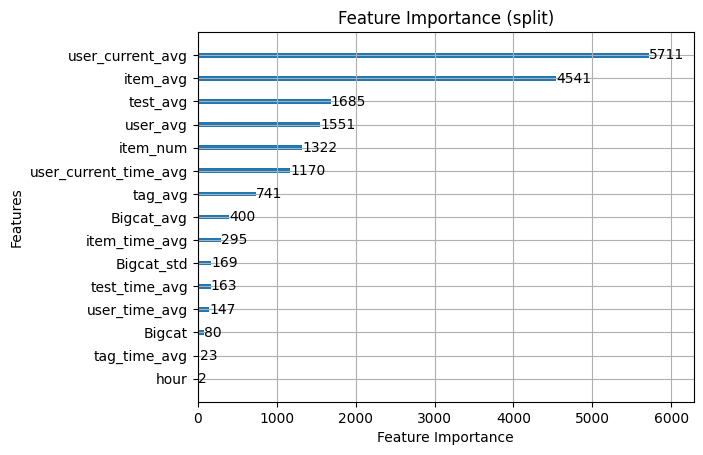

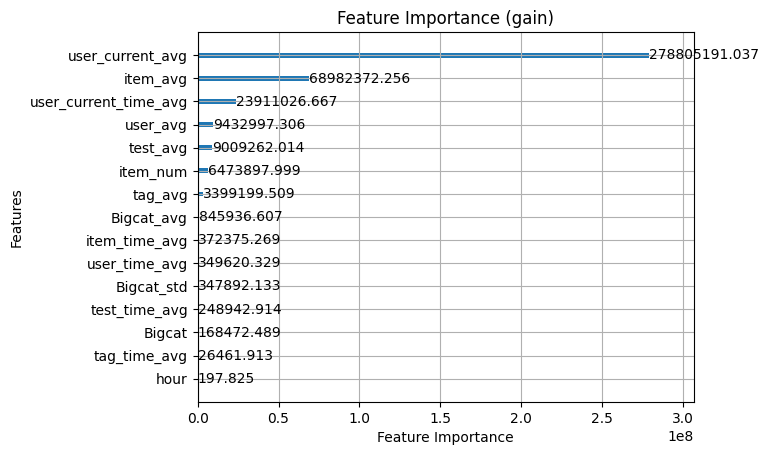

In [8]:
# model: 이미 학습이 완료된 LGBMModel, or Booster
# FEATURES: model 학습에 사용된 모든 features
# PATH: 그림을 저장할 경로

# SPLIT
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_split.png', dpi=300)


# GAIN
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_gain.png', dpi=300)